# LOS Prediction - Feedforward Deep Neural Network

This notebook predicts the hospital length of stay using the first 24 or 48 hour processed MIMIC-III dataset.

Here, we attempt to train with varying layers, hidden units, and other tunable hyperparameters to achieve the optimal performance on the validation set. 

Later on, we try to improve the performance by running feature selection before hand. For that see `los_prediction_after_feature_selection` notebook.



In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU

import numpy as np

print(tf.__version__)

2.0.0


Using TensorFlow backend.


In [4]:

raw_dataset = pd.read_csv('../data/exp/pneumonia-t3/first48hours.csv', header=0)
df = raw_dataset.copy()

df = df.loc[:, (df==0).mean() < .7]
df.fillna(0, inplace=True)
df = df.replace([np.inf, -np.inf], 0)

# Remove rows where the chartevents aren't available
df = df[df['Heart Rate'] > 0]

# Shuffle data because data is ordered by admittime currently
df = df.sample(frac=1).reset_index(drop=True)
df.tail()


,los,age,gender,insurance,language,religion,marital_status,ethnicity,Anion Gap,Anion Gap-trend,...,Systolic,Systolic-trend,O2 Flow.1,O2 Flow-trend.1,Respiratory Rate,Respiratory Rate-trend,Temperature.1,Temperature-trend.1,O2,O2-trend
3880,7.777,91.4000,M,Medicare,SPAN,CATHOLIC,MARRIED,HISPANIC OR LATINO,13.5,-0.012,...,131.911,0.384,2.80,-0.188,20.128,0.028,0.000,0.000,94.426,-0.050
3881,7.450,91.4000,M,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,17.0,0.015,...,119.333,2.594,3.00,0.000,57.394,0.108,37.231,0.131,0.000,0.000
3882,26.160,74.6190,F,Medicare,ENGL,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN,16.0,-0.122,...,122.333,-0.566,0.00,0.000,22.446,-0.031,0.000,0.000,96.611,0.068
3883,0.935,65.8139,M,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,15.5,0.074,...,92.429,-1.956,11.25,0.692,32.640,0.047,0.000,0.000,91.440,-0.489
3884,12.273,57.6221,F,Medicare,0,UNOBTAINABLE,SINGLE,WHITE,13.0,-0.122,...,102.167,0.500,0.00,0.000,56.403,0.162,45.146,0.433,0.000,0.000


In [12]:
df[df.gender == 'M'].shape[0]

2127

In [205]:
# Check for any zero columns
zeros = df.isna().sum()
c = 0
for z in zeros:
    if z > 0:
        print(c)
    c += 1


In [206]:
# One hot encode the demographic columns
# (comment out if we don't want to use the demographic columns at all)
# 
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    #df = df.join(one_hot)
df

,los,age,Anion Gap,Anion Gap-trend,Basophils,Bicarbonate,Bicarbonate-trend,Chloride,Chloride-trend,Creatinine,...,Systolic,Systolic-trend,O2 Flow.1,O2 Flow-trend.1,Respiratory Rate,Respiratory Rate-trend,Temperature.1,Temperature-trend.1,O2,O2-trend
0,19.340,61.1293,12.250,0.024,0.000,23.000,0.112,106.750,-0.208,0.875,...,99.438,0.809,3.875,0.064,55.698,0.127,37.167,0.051,0.000,0.000
1,8.858,62.8925,9.667,-0.072,0.200,36.667,-0.061,99.000,0.177,0.367,...,109.214,-3.617,15.000,0.000,57.697,0.026,35.856,-0.014,0.000,0.000
2,9.812,80.8916,23.833,0.171,0.000,18.667,-0.214,91.000,-0.015,6.917,...,116.426,0.230,0.000,0.000,61.021,0.132,49.222,0.751,0.000,0.000
3,3.725,91.4000,16.500,-0.541,0.200,24.500,0.541,105.500,0.180,1.000,...,103.405,0.490,7.455,-0.045,21.690,-0.097,0.000,0.000,94.659,-0.331
4,3.200,31.1492,13.000,-0.000,0.600,20.500,0.041,108.500,-0.124,0.750,...,88.410,-0.153,2.000,-0.000,18.854,-0.067,0.000,0.000,95.976,-0.018
5,13.106,53.7014,16.000,0.090,0.000,24.250,0.030,103.500,0.041,1.350,...,137.111,-0.136,0.000,0.000,26.892,-0.094,0.000,0.000,97.079,-0.005
6,24.053,70.0467,13.667,-0.104,0.000,20.333,-0.035,109.667,0.175,0.667,...,122.625,1.045,2.000,-0.000,25.478,0.207,0.000,0.000,96.791,-0.101
7,8.134,91.4000,10.800,-0.071,0.050,28.800,0.056,106.200,0.042,1.180,...,132.314,-0.363,6.300,-0.294,21.741,0.112,0.000,0.000,95.018,-0.111
8,8.899,59.3278,11.750,-0.028,0.500,25.750,-0.001,104.000,0.024,1.200,...,104.852,0.246,3.000,-0.001,15.089,0.031,0.000,0.000,97.482,0.010
9,7.694,66.8872,13.000,-0.000,0.600,26.333,-0.054,106.667,0.047,0.533,...,129.226,0.522,10.000,0.000,62.952,-0.038,37.228,-0.031,0.000,0.000


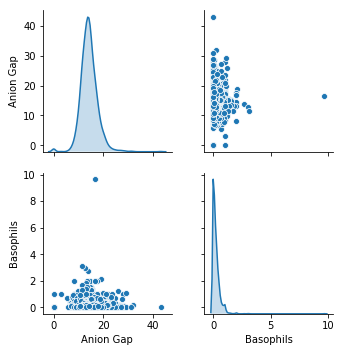

In [207]:
train_dataset = df.sample(frac=0.7,random_state=0)
test_dataset = df.drop(train_dataset.index)

sns.pairplot(train_dataset[["Anion Gap", "Basophils"]], diag_kind="kde")


In [208]:
train_stats = train_dataset.describe()
train_stats.pop("los")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,2720.0,65.818905,18.754170,0.000,54.61450,68.3629,80.42205,91.400
Anion Gap,2720.0,14.211543,3.316519,0.000,12.25000,14.0000,16.00000,43.000
Anion Gap-trend,2720.0,-0.058711,0.131223,-2.000,-0.10900,-0.0480,0.00200,0.591
Basophils,2720.0,0.231483,0.347433,0.000,0.00000,0.1500,0.30000,9.667
Bicarbonate,2720.0,25.050044,5.443505,0.000,22.00000,24.6670,28.00000,50.667
Bicarbonate-trend,2720.0,0.001775,0.135160,-2.069,-0.06500,0.0000,0.06925,2.500
Chloride,2720.0,102.959126,9.301168,0.000,99.75000,103.5000,107.00000,139.286
Chloride-trend,2720.0,0.074623,0.196826,-1.250,-0.01500,0.0580,0.15400,4.249
Creatinine,2720.0,1.416244,1.461487,0.000,0.70000,0.9670,1.53300,21.680
Creatinine-trend,2720.0,-0.003860,0.018807,-0.264,-0.00700,-0.0020,0.00100,0.097


In [209]:
train_labels = train_dataset.pop('los')
test_labels = test_dataset.pop('los')

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [210]:
# Number of input keys
len(train_dataset.keys())

114

In [238]:
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
def build_model():
  model = keras.Sequential([
    layers.Dense(96, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(96, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_2'),
    layers.Dense(96, activation='relu', input_shape=[len(train_dataset.keys())]),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
#     layers.Dropout(0.5, name='dropout_1'),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
#     layers.Dropout(0.5, name='dropout_2'),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
    layers.Dense(1)
  ])

#   optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


In [239]:
model = build_model()

In [240]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 96)                11040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 96)                9312      
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 96)                9312      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 97        
Total params: 29,761
Trainable params: 29,761
Non-trainable params: 0
_________________________________________________

In [241]:
example_batch = normed_train_data[:3]
example_batch
example_result = model.predict(example_batch)
example_result

# Find any inf values
# normed_train_data.index[np.isinf(normed_train_data).any(1)]

array([[-0.06592108],
       [ 0.11825478],
       [ 0.18880747]], dtype=float32)

In [242]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................

In [243]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,39.958310,4.319187,39.958309,88.432170,5.748659,88.432159,95
96,39.195779,4.355801,39.195770,87.237893,5.715681,87.237892,96
97,34.449442,4.239364,34.449440,89.139873,5.757772,89.139870,97
98,35.265483,4.230230,35.265480,88.162025,5.749772,88.162018,98
99,41.504421,4.306052,41.504414,90.087047,5.796409,90.087051,99


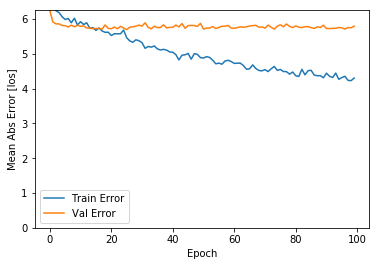

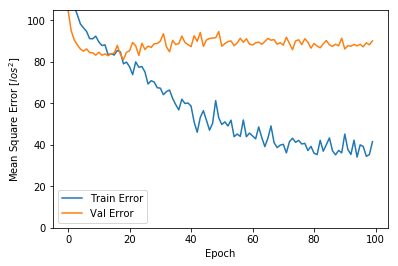

In [244]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,max(hist['val_mae'])])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$los^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,max(hist['val_mse'])])
  plt.legend()
  plt.show()


plot_history(history)

# hist = pd.DataFrame(history.history)
# hist['val_mae']

In [245]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.average(hist['val_mae'][10:])

5.773174503114489